In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\marku\Documents\SteelProdData_Project\src\scripts")

In [2]:
train_data_orig = pd.read_csv('C:\\Users\\marku\\Documents\\SteelProdData_Project\\data\\raw\\normalized_train_data.csv')
test_data_orig = pd.read_csv('C:\\Users\\marku\\Documents\\SteelProdData_Project\\data\\raw\\normalized_test_data.csv')


In [3]:
conc_data=pd.concat([train_data_orig, test_data_orig], ignore_index=True)

In [4]:
#Check for missing values

# Define a set of values that should be treated as empty/missing
EMPTY_TOKENS = {"", " ", "NA", "N/A", "null", "None", "nan", "-"}

# Create a copy of the dataframe to avoid modifying the original
conc_data_check = conc_data.copy()

# Convert empty strings and placeholder values to NaN in object columns
obj_cols = conc_data_check.select_dtypes(include=["object"]).columns
for c in obj_cols:
    conc_data_check[c] = (
        conc_data_check[c]
        .astype(str)        # Convert all values to strings
        .str.strip()        # Remove leading/trailing whitespace
        .replace(EMPTY_TOKENS, np.nan)  # Replace empty tokens with NaN
    )

# Create a summary dataframe with statistics about each column
summary = pd.DataFrame({
    "dtype": conc_data_check.dtypes.astype(str),      # Data type of each column
    "rows_total": len(conc_data_check),               # Total number of rows
    "non_null": conc_data_check.notna().sum(),        # Count of non-null values
    "nulls": conc_data_check.isna().sum(),            # Count of null values
    "null_frac": (conc_data_check.isna().mean()),     # n_NaN/n_all_Entries
    "n_unique": conc_data_check.nunique(dropna=True), # Count of unique non-null values
})
# Sort the summary by null fraction
summary = summary.sort_values("null_frac", ascending=False)


display(summary)

,dtype,rows_total,non_null,nulls,null_frac,n_unique
output,float64,10979,10979,0,0.0,250
input1,float64,10979,10979,0,0.0,5
input20,float64,10979,10979,0,0.0,51
input19,float64,10979,10979,0,0.0,210
input18,float64,10979,10979,0,0.0,42
input17,float64,10979,10979,0,0.0,164
input16,float64,10979,10979,0,0.0,70
input15,float64,10979,10979,0,0.0,44
input14,float64,10979,10979,0,0.0,55
input13,float64,10979,10979,0,0.0,76


In [5]:
#Replace missing values with mean of the columns -Not necessary
numerical_cols = conc_data.select_dtypes(include=np.number).columns.tolist() 
conc_data[numerical_cols] = conc_data[numerical_cols].apply(lambda x: x.fillna(x.mean()), axis=0) # Fill NaN with column mean

In [6]:
#Check for duplicates

# Count duplicate rows based on all input and output columns
n_dup = conc_data_check.duplicated().sum()
print(f"Duplikate über input1..input21 + output: {n_dup}")

# Display duplicate rows
dup_rows = conc_data_check[conc_data_check.duplicated(keep=False)].copy()

display(dup_rows.head(5))  # Display first 5 duplicate rows


Duplikate über input1..input21 + output: 0


,output,input1,input2,input3,input4,input5,input6,input7,input8,input9,...,input12,input13,input14,input15,input16,input17,input18,input19,input20,input21


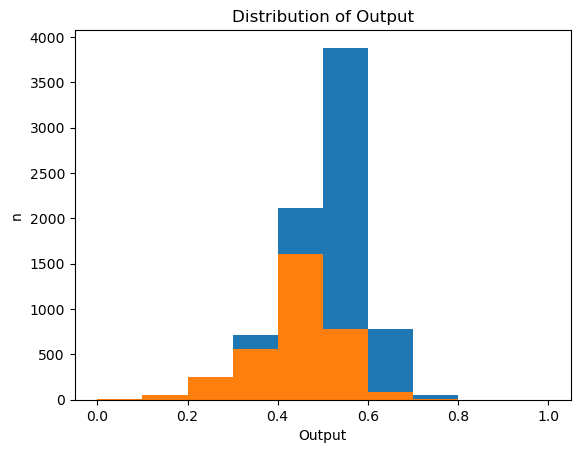

In [7]:
plt.hist(train_data_orig["output"])
plt.hist(test_data_orig["output"])
plt.xlabel('Output')
plt.ylabel('n') 
plt.title('Distribution of Output')
plt.show()

In [ ]:
import seaborn as sns

g=sns.pairplot(conc_data.sample(n=300, random_state=42)) #Plot pairwise relationships with sample of 300 rows

In [ ]:
#Heatmap

num_cols = conc_data.select_dtypes(include=["number"]).columns.tolist()
num_cols.remove("output")                             #Remove column output from correlation analysis


corr_cols = num_cols[:] 
corr = conc_data[corr_cols].corr()  
plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.title("Korrelation")
plt.colorbar()

plt.xticks(range(len(corr_cols)), corr_cols, rotation=90, fontsize=8)
plt.yticks(range(len(corr_cols)), corr_cols, fontsize=8)

plt.tight_layout()
plt.show()

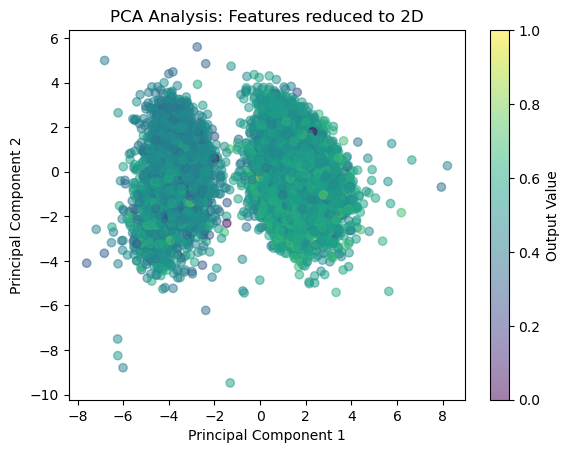

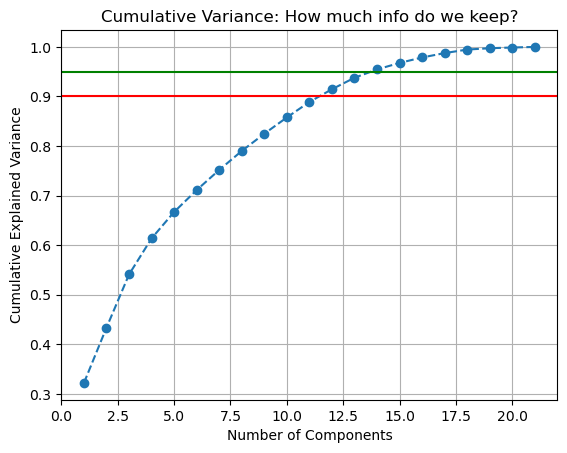

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X=conc_data.drop("output" , axis=1 ).values
y=conc_data["output"].values

# Standardize the inputs (PCA works best when data is centered)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce the 21 features down to just 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_2=PCA() #For plotting cumulative variance
pca_2.fit(X_scaled)

# Create the scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Output Value')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis: Features reduced to 2D')
plt.show()

cumulative_variance=np.cumsum(pca_2.explained_variance_ratio_)

plt.plot(range(1,22),cumulative_variance, marker='o', linestyle='--')

plt.axhline(y=0.90, color='r', linestyle='-', label='90% Variance')
plt.axhline(y=0.95, color='g', linestyle='-', label='95% Variance')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance: How much info do we keep?')
plt.grid(True)
plt.show()

In [8]:
#Test/Train_Split
X=conc_data.drop("output" , axis=1 ).values
y=conc_data["output"].values


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=35)


In [9]:
#Establish Baseline Model with Linear Regression

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
#s=StandardScaler()       #Data is standardized using Min-Max Scaling
#s.fit(X_train) 

#X_train_trans= s.transform(X_train) 
#X_test_trans=s.transform(X_test)

model_lr=LinearRegression()

model_lr.fit(X_train, y_train)

print(model_lr.score(X_test,y_test))

0.25844371216463946


In [10]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

model_rfreg=RandomForestRegressor()

model_rfreg.fit(X_train, y_train)

print(model_rfreg.score(X_test,y_test))

0.47418817653118617


In [ ]:
#Standard Gaussian Process (RBF and COnstant Kernel)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define the kernel (covariance function)
# Here we use a constant kernel multiplied by an RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
model_gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
model_gp.fit(X_train, y_train)

from plot_helper import evaluate_model, plot_data
evaluate_model(model_gp, X_test, y_test)
plot_data(X_test, y_test, model_gp.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

In [22]:
# Add the specific gpytorch site-packages path to sys.path and try import
import sys
sys.path.append(r'c:\users\marku\appdata\local\packages\pythonsoftwarefoundation.python.3.13_qbz5n2kfra8p0\localcache\local-packages\python313\site-packages')

#sys.path.append(r'C:\Users\marku\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\Scripts')

In [ ]:
#Mixed Gaussian Process (COnstant Kernel, Matern, DotProduct, Noise)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, DotProduct, WhiteKernel, ConstantKernel

# Define the kernel (covariance function)

kernel = (ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=[1.0]*21, nu=1.5) + 
    DotProduct(sigma_0=1.0) + 
    WhiteKernel(noise_level=0.1)
)
model_gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)
model_gp.fit(X_train, y_train)

from plot_helper import evaluate_model, plot_data
evaluate_model(model_gp, X_test, y_test)
plot_data(X_test, y_test, model_gp.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

In [23]:
import torch

# 1. Check if CUDA is reachable
print(f"CUDA is available: {torch.cuda.is_available()}")

# 2. Check the version PyTorch is using
print(f"PyTorch CUDA version: {torch.version.cuda}")

# 3. Check the GPU name
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

CUDA is available: True
PyTorch CUDA version: 11.8
Using GPU: NVIDIA GeForce RTX 3070


Using device: cuda
Iter 1/100 - Loss: 1.1272
Iter 2/100 - Loss: 1.0729
Iter 3/100 - Loss: 1.0230
Iter 4/100 - Loss: 0.9763
Iter 5/100 - Loss: 0.9302
Iter 6/100 - Loss: 0.8847
Iter 7/100 - Loss: 0.8400
Iter 8/100 - Loss: 0.7942
Iter 9/100 - Loss: 0.7485
Iter 10/100 - Loss: 0.6987
Iter 11/100 - Loss: 0.6492
Iter 12/100 - Loss: 0.5958
Iter 13/100 - Loss: 0.5436
Iter 14/100 - Loss: 0.4919
Iter 15/100 - Loss: 0.4364
Iter 16/100 - Loss: 0.3825
Iter 17/100 - Loss: 0.3259
Iter 18/100 - Loss: 0.2679
Iter 19/100 - Loss: 0.2123
Iter 20/100 - Loss: 0.1568
Iter 21/100 - Loss: 0.0982
Iter 22/100 - Loss: 0.0419
Iter 23/100 - Loss: -0.0145
Iter 24/100 - Loss: -0.0692
Iter 25/100 - Loss: -0.1246
Iter 26/100 - Loss: -0.1822
Iter 27/100 - Loss: -0.2349
Iter 28/100 - Loss: -0.2910
Iter 29/100 - Loss: -0.3455
Iter 30/100 - Loss: -0.3981
Iter 31/100 - Loss: -0.4523
Iter 32/100 - Loss: -0.5076
Iter 33/100 - Loss: -0.5544
Iter 34/100 - Loss: -0.6057
Iter 35/100 - Loss: -0.6560
Iter 36/100 - Loss: -0.7073
Iter

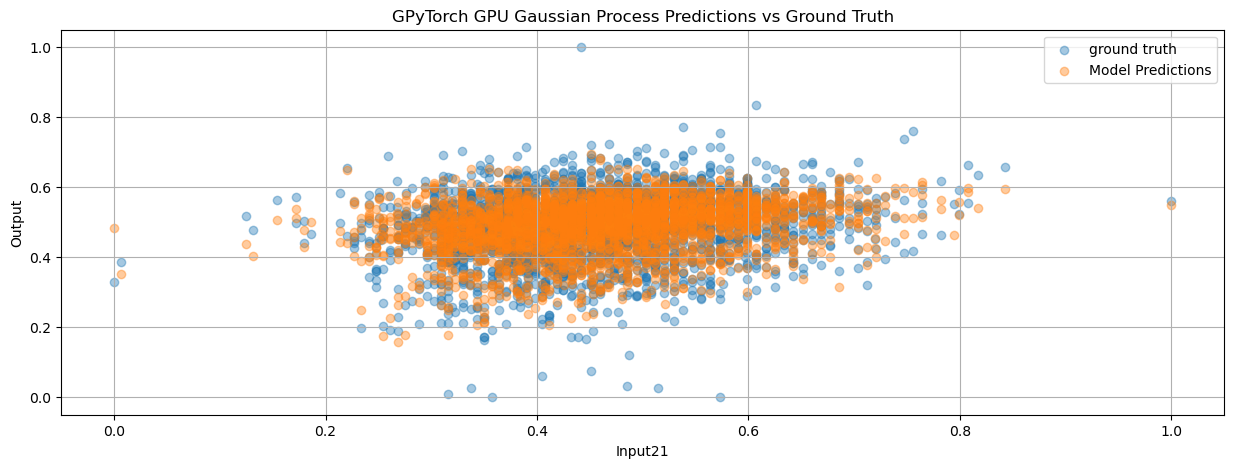

In [24]:
# GPU-accelerated Gaussian Process using GPyTorch (uses CUDA if available)
import torch
import gpytorch
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

s=StandardScaler()       #Data is standardized using Min-Max Scaling; standardised to make variances comparable
s.fit(X_train) 

X_train_trans= s.transform(X_train) 
X_test_trans=s.transform(X_test)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
# Convert numpy data to torch tensors on the selected device
X_train_t = torch.from_numpy(X_train_trans.astype(np.float32)).to(device)
y_train_t = torch.from_numpy(y_train.astype(np.float32)).to(device)
X_test_t = torch.from_numpy(X_test_trans.astype(np.float32)).to(device)
y_test_t = torch.from_numpy(y_test.astype(np.float32)).to(device)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=21)
        ) + gpytorch.kernels.LinearKernel()
        #self.covar_module[0].outputscale = 1.2 #Manually set the initial weight, since preds are offset in plot_data

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model_gt = ExactGPModel(X_train_t, y_train_t, likelihood).to(device)

# Train the model (MAP / MLE for hyperparameters)
model_gt.train()
likelihood.train()

optimizer = torch.optim.Adam(model_gt.parameters(), lr=0.1) 
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_gt)

training_iter = 100
for i in range(training_iter):
    optimizer.zero_grad()
    output = model_gt(X_train_t)
    loss = -mll(output, y_train_t)
    loss.backward()
    print(f'Iter {i+1}/{training_iter} - Loss: {loss.item():.4f}')
    optimizer.step()
# Evaluation (use fast_pred_var for speed)
model_gt.eval()
likelihood.eval()

with torch.no_grad():
    preds = likelihood(model_gt(X_test_t))
    mean = preds.mean.cpu().numpy()
# Metrics and plotting
r2 = r2_score(y_test, mean)
mae = mean_absolute_error(y_test, mean)
mse = mean_squared_error(y_test, mean)
print(f'GPyTorch GPU GP — R2: {r2:.4f}, MAE: {mae:.4f}, MSE: {mse:.4f}')
from plot_helper import plot_data
plot_data(X_test, y_test, mean, title='GPyTorch GPU Gaussian Process Predictions vs Ground Truth')

In [11]:
from keras.models import Sequential
from keras.layers import Dense  

model_dnnstd = Sequential()
model_dnnstd.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],) )) #21 Inputs
model_dnnstd.add(Dense(1,activation='linear'))

model_dnnstd.compile(optimizer='adam', loss='mse', metrics=['mae'])


history_dnnstd=model_dnnstd.fit(
          X_train,
          y_train,
          epochs=100,
          batch_size=32)



Epoch 1/100


Epoch 1/100


c:\Users\marku\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\marku\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


c:\Users\marku\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
c:\Users\marku\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0112 - mae: 0.0779  
Epoch 2/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.0072 - mae: 0.0660
Epoch 3/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.0071 - mae: 0.0653
Epoch 4/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0069 - mae: 0.0644
Epoch 5/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - loss: 0.0071 - mae: 0.0657
Epoch 6/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 0.0066 - mae: 0.0630
Epoch 7/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0064 - mae: 0.0622
Epoch 8/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 0.0063 - mae: 0.0622
Epoch 9/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 0.0064 - mae: 0.0628
Epoch 10/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 0.0062 - mae: 0.0611
Epoch 11/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 0.0062 - mae: 0.0615
Epoch 12/100
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 0.0061 - mae: 0.0605
E

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
model_dnnopt = models.Sequential()
model_dnnopt.add(Dense(512, activation='relu', input_shape=(21,),kernel_regularizer=regularizers.l2(1e-4))) #21 Inputs
model_dnnopt.add(layers.BatchNormalization())


model_dnnopt.add(Dense(256, activation='relu'))
model_dnnopt.add(layers.Dropout(0.3))
model_dnnopt.add(Dense(128, activation='relu'))
model_dnnopt.add(layers.BatchNormalization())

model_dnnopt.add(Dense(64, activation='relu'))
model_dnnopt.add(Dense(64, activation='relu'))
model_dnnopt.add(Dense(1,activation='linear'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_dnnopt.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae','mse'])




In [13]:
lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,    # Cut LR by 80% when progress stalls
    patience=5, 
    min_lr=1e-7,
    verbose=1
)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=12, 
    restore_best_weights=True
)


history_dnnopt = model_dnnopt.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,          # Increased epochs to allow LR scheduler to work
    batch_size=32,      
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0252 - mae: 0.1466 - mse: 0.0444 - val_loss: 0.0110 - val_mae: 0.0990 - val_mse: 0.0157 - learning_rate: 0.0010
Epoch 2/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - mae: 0.0857 - mse: 0.0119 - val_loss: 0.0074 - val_mae: 0.0710 - val_mse: 0.0089 - learning_rate: 0.0010
Epoch 3/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - mae: 0.0762 - mse: 0.0095 - val_loss: 0.0066 - val_mae: 0.0647 - val_mse: 0.0075 - learning_rate: 0.0010
Epoch 4/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - mae: 0.0725 - mse: 0.0086 - val_loss: 0.0072 - val_mae: 0.0778 - val_mse: 0.0093 - learning_rate: 0.0010
Epoch 5/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0063 - mae: 0.0683 - mse: 0.0076 - val_loss: 0.0060 - val_mae: 0.0633 - val_mse: 0.0073 - learning_rate: 0.0010
Epoch 6/200
258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0058 - mae: 0.0656 - mse: 0.0071 - val_loss: 0.0064 - val_mae:

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Evaluation Metrics
     Metric     Value
0  R² Score  0.421962
1      RMSE  0.072274
2       MAE  0.053261
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


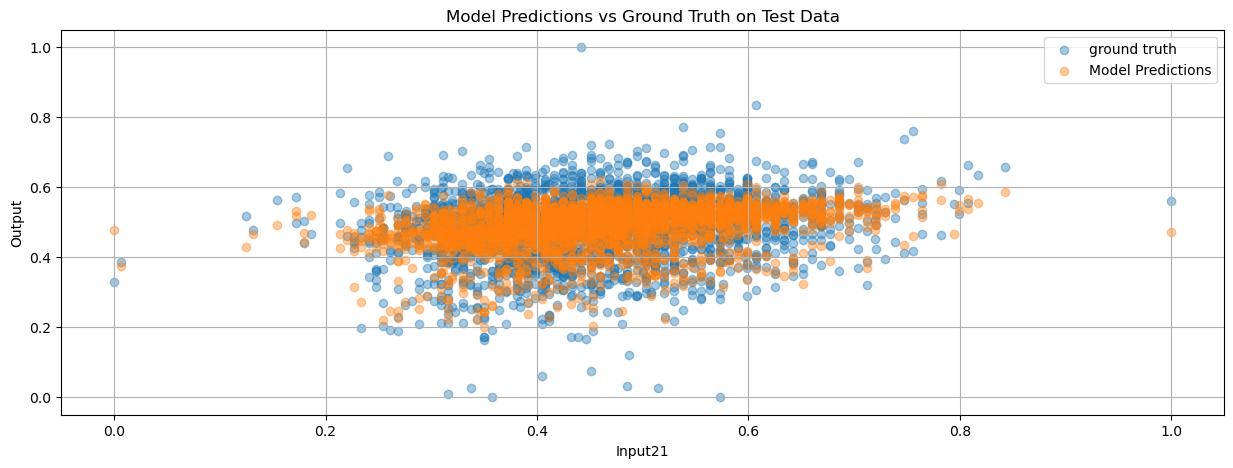

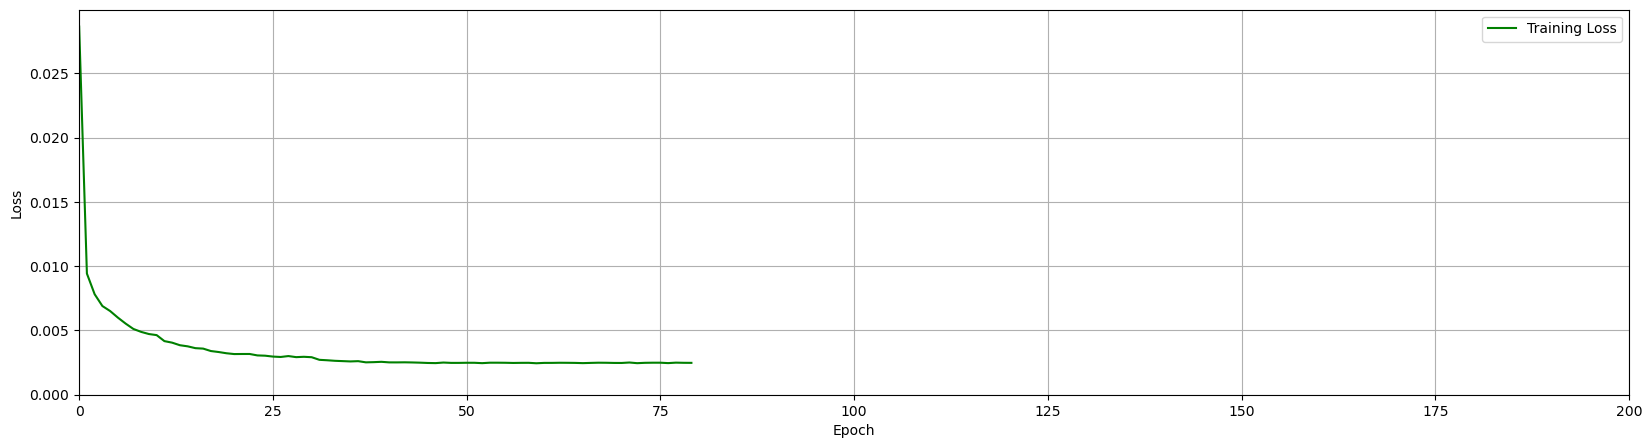

In [35]:
from plot_helper import evaluate_model, plot_data, plot_loss
evaluate_model(model_dnnopt, X_test, y_test)
plot_data(X_test, y_test, model_dnnopt.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")
plot_loss(history_dnnopt)

Model Evaluation Metrics
     Metric     Value
0  R² Score  0.258444
1      RMSE  0.081861
2       MAE  0.061824


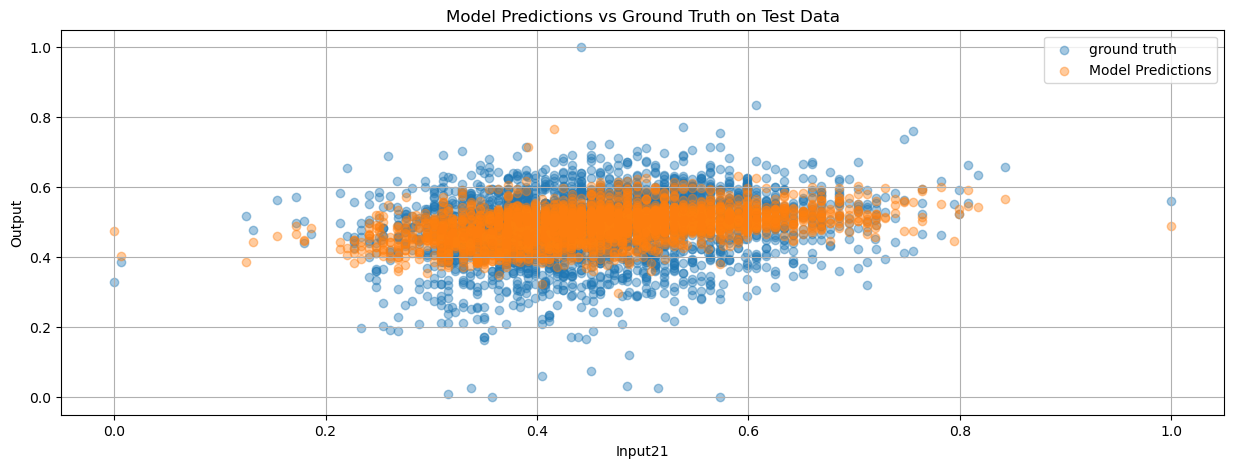

In [36]:
#Eval linear regression

from plot_helper import evaluate_model, plot_data
evaluate_model(model_lr, X_test, y_test)
plot_data(X_test, y_test, model_lr.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

Model Evaluation Metrics
     Metric     Value
0  R² Score  0.474188
1      RMSE  0.068932
2       MAE  0.049975


Model Evaluation Metrics
     Metric     Value
0  R² Score  0.474188
1      RMSE  0.068932
2       MAE  0.049975


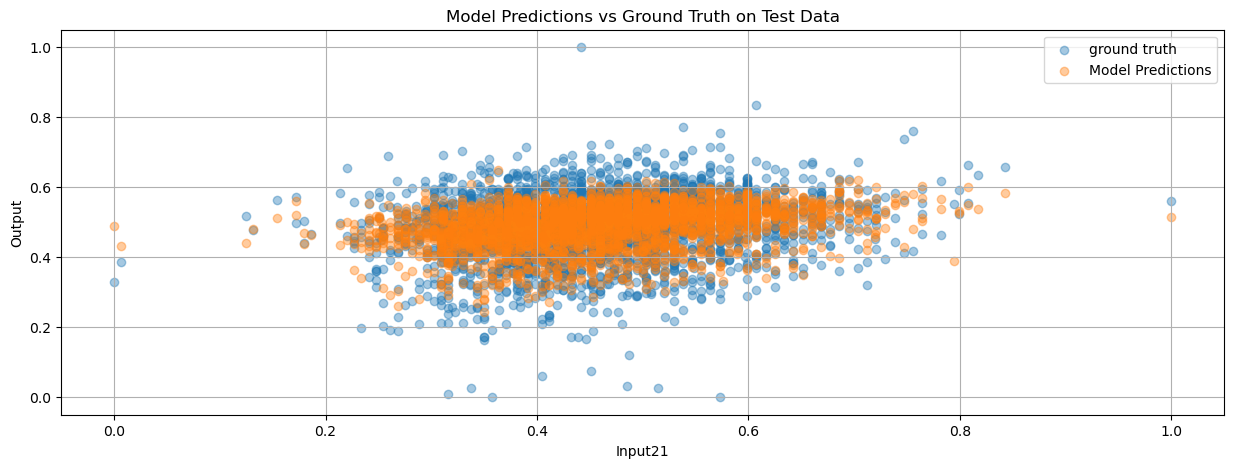

In [14]:
#Eval RFRegressor

from plot_helper import evaluate_model, plot_data
evaluate_model(model_rfreg, X_test, y_test)
plot_data(X_test, y_test, model_rfreg.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
Model Evaluation Metrics
     Metric     Value
0  R² Score  0.368968
1      RMSE  0.075514
2       MAE  0.056244
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step


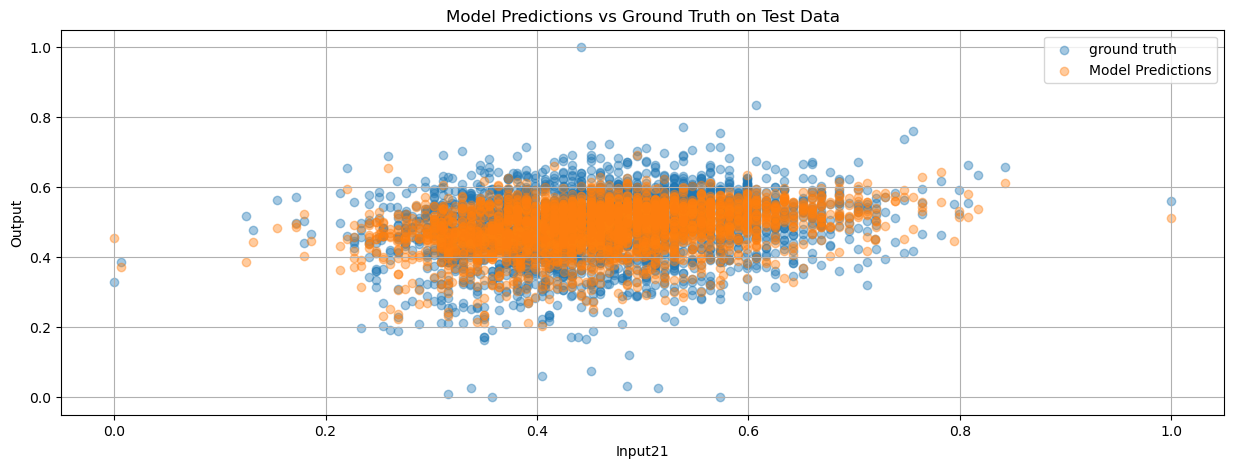

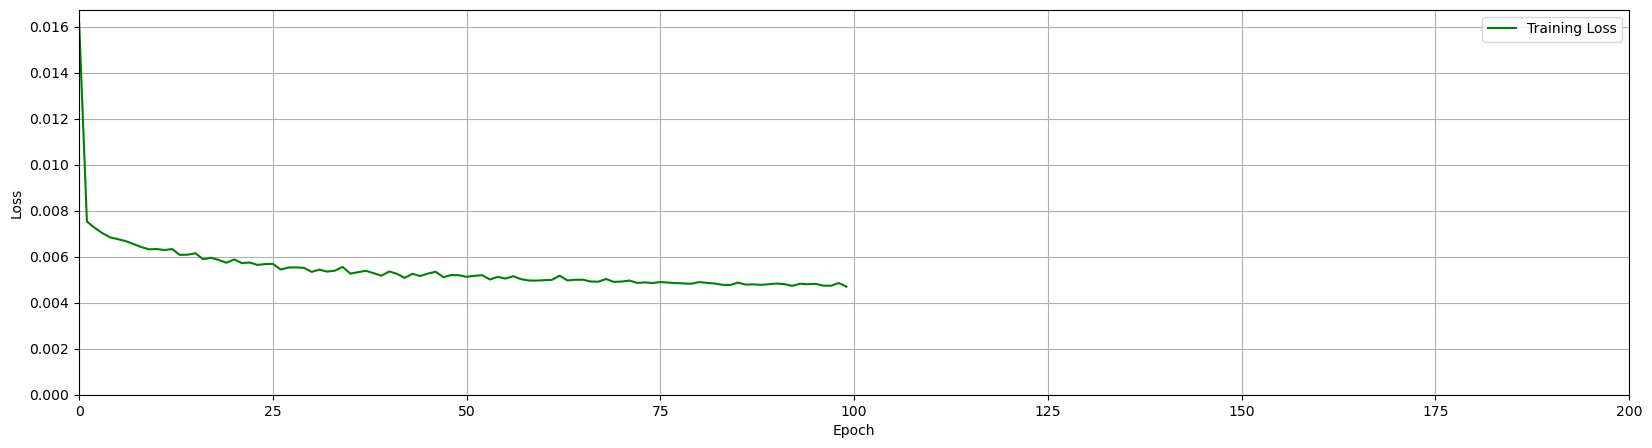

In [40]:
#Eval DNN standard

from plot_helper import evaluate_model, plot_data
evaluate_model(model_dnnstd, X_test, y_test)
plot_data(X_test, y_test, model_dnnstd.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")
plot_loss(history_dnnstd)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model Evaluation Metrics
     Metric     Value
0  R² Score  0.421962
1      RMSE  0.072274
2       MAE  0.053261
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step


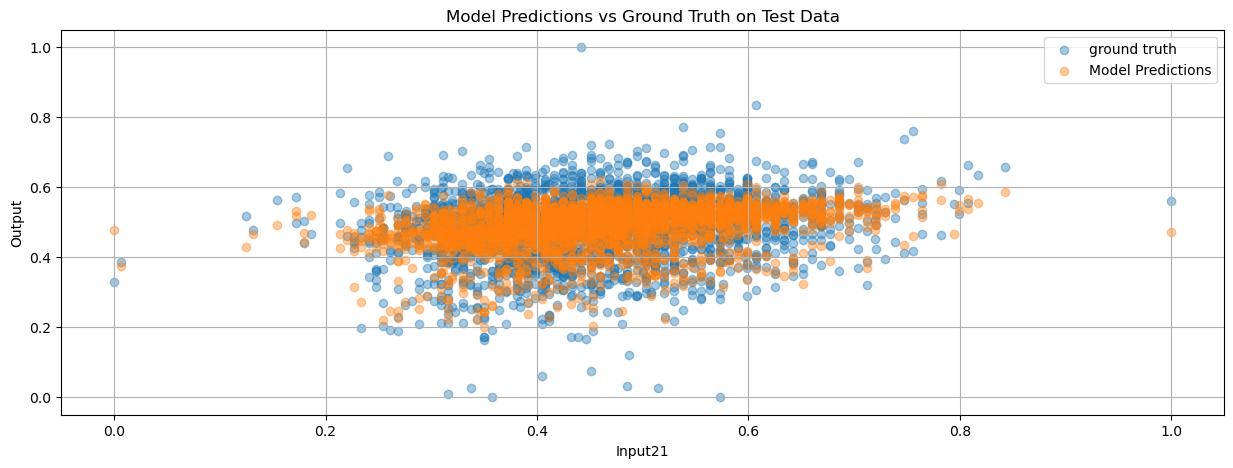

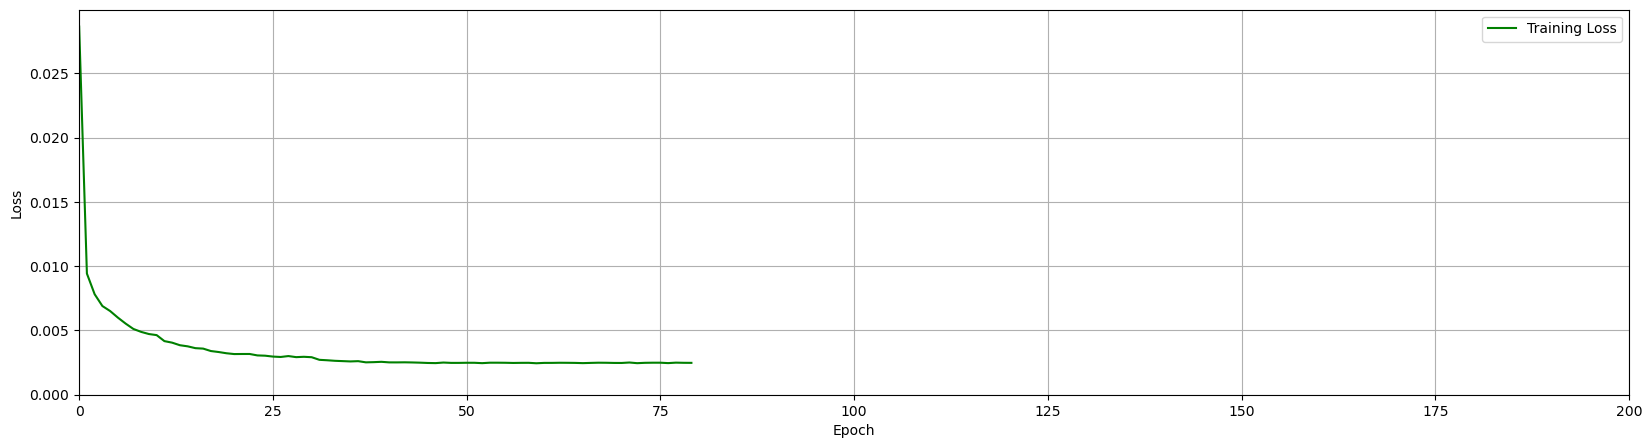

In [41]:
#Eval DNN optimized

from plot_helper import evaluate_model, plot_data
evaluate_model(model_dnnopt, X_test, y_test)
plot_data(X_test, y_test, model_dnnopt.predict(X_test), title="Model Predictions vs Ground Truth on Test Data")
plot_loss(history_dnnopt)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step


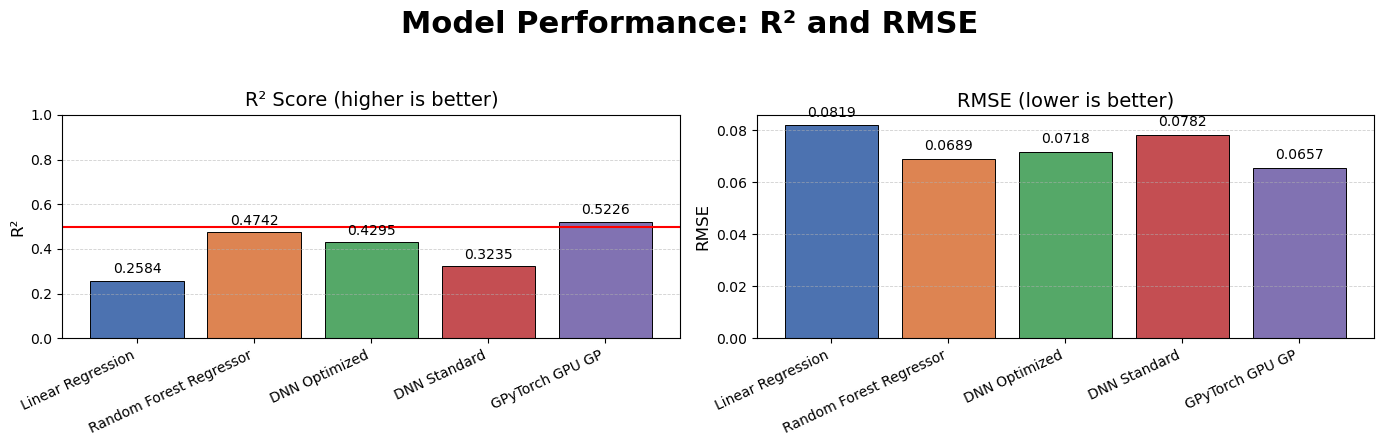

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

names = ['Linear Regression', 'Random Forest Regressor', 'DNN Optimized', 'DNN Standard', 'GPyTorch GPU GP']
models_map = {
    'Linear Regression': globals().get('model_lr'),
    'Random Forest Regressor': globals().get('model_rfreg'),
    'DNN Optimized': globals().get('model_dnnopt'),
    'DNN Standard': globals().get('model_dnnstd'),
    'GPyTorch GPU GP': globals().get('model_gt'),
}
r2_list = []
rmse_list = []
for n in names:
    if n == 'GPyTorch GPU GP':  #Pytorch model needs special handling as in above cell
        with torch.no_grad(): 
            preds = likelihood(model_gt(X_test_t)) #equal to scikit learn .predict()
            preds = preds.mean.cpu().numpy() #convert to numpy on CPU
    else:
        mdl = models_map.get(n)
        preds = mdl.predict(X_test)
        preds = np.asarray(preds).reshape(-1)

    r2 = r2_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2_list.append(r2)
    rmse_list.append(rmse)

r2s = np.array(r2_list, dtype=float)
rmses = np.array(rmse_list, dtype=float)


colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52', '#8172B2']

# Create wide figure with two subplots side-by-side
fig = plt.figure(figsize=(14, 4.5))
fig.suptitle('Model Performance: R² and RMSE', fontsize=22, fontweight='bold')

# Left subplot: R²
ax1 = fig.add_subplot(1, 2, 1)
x = np.arange(len(names))
bars1 = ax1.bar(x, r2s, color=colors, edgecolor='black', linewidth=0.7)
ax1.set_xticks(x)
ax1.set_xticklabels(names, rotation=25, ha='right', fontsize=10)
ax1.set_ylabel('R²', fontsize=12)
ax1.set_ylim(0.0, 1.0)
ax1.set_title('R² Score (higher is better)', fontsize=14)
ax1.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.axhline(y=0.50, color='r', linestyle='-', label='50% R2')

# Add numeric labels above each R² bar
for rect, val in zip(bars1, r2s):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Right subplot: RMSE
ax2 = fig.add_subplot(1, 2, 2)
bars2 = ax2.bar(x, rmses, color=colors, edgecolor='black', linewidth=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(names, rotation=25, ha='right', fontsize=10)
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_title('RMSE (lower is better)', fontsize=14)
ax2.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)

# Add numeric labels above each RMSE bar
for rect, val in zip(bars2, rmses):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 0.0022, f'{val:.4f}', ha='center', va='bottom', fontsize=10)

# Tidy layout and show
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()
